In [1]:
from __future__ import division

In [2]:
from aqchem.chemistry import Solute
from aqchem.equilibria import Equilibrium, EqSystem, charge_balance, atom_balance
import periodictable
import numpy as np

In [3]:
substances = Hp, OHm, NH4p, NH3, H2O = [
    Solute(n, formula=periodictable.formula(n)) for n in [
        'H{+}', 'HO{-}', 'NH3 + H{+}', 'NH3', 'H2O']]
assert (Hp.charge, OHm.charge, NH4p.charge, NH3.charge, H2O.charge) == (1, -1, 1, 0, 0)

In [4]:
init_conc = {Hp: 1e-7, OHm: 1e-7, NH4p: 1e-7, NH3: 1.0, H2O: 55.5}
x0 = [init_conc[k] for k in substances]
H2O_c = init_conc[H2O]
w_autop = Equilibrium({H2O: 1}, {Hp: 1, OHm: 1}, 10**-14/H2O_c)
NH4p_pr = Equilibrium({NH4p: 1}, {Hp: 1, NH3: 1}, 10**-9.26)
equilibria = w_autop, NH4p_pr

In [5]:
reaction_system = EqSystem(equilibria, substances)

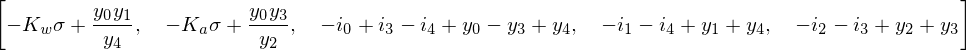

In [6]:
import sympy as sp
sp.init_printing()
ny = len(substances)
y = sp.symarray('y', ny)
i = sp.symarray('i', ny)
Kw, Ka, sigma = sp.symbols('K_w K_a sigma')
w_autop.params = Kw
NH4p_pr.params = Ka
rs = EqSystem(equilibria, substances)
f = rs.f(y, i, scaling=sigma)
f

In [7]:
j = sp.Matrix(1, len(y), lambda _, q: f[q]).jacobian(y)
jarr = np.array(j.subs(zip(y,x0)))
jarr = np.asarray(jarr, dtype=np.float64)
np.linalg.inv(jarr)

array([[  1.85000006e+08,   3.33333311e-08,   3.33333345e-01,
         -3.33333344e-01,   3.33333311e-01],
       [  3.69999993e+08,  -3.33333311e-08,  -3.33333344e-01,
          3.33333345e-01,  -3.33333311e-01],
       [  1.84999987e+08,  -6.66666622e-08,   3.33333311e-01,
         -3.33333311e-01,   3.33333378e-01],
       [ -1.84999987e+08,   6.66666622e-08,  -3.33333311e-01,
          3.33333311e-01,   6.66666622e-01],
       [ -3.69999993e+08,   3.33333311e-08,   3.33333344e-01,
          6.66666655e-01,   3.33333311e-01]])

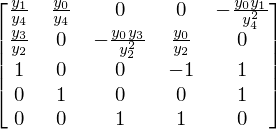

In [8]:
j

In [9]:
[s.name for s in rs.substances]

['H{+}', 'HO{-}', 'NH3 + H{+}', 'NH3', 'H2O']

In [10]:
rs.charge_balance_vector(), rs.atom_balance_vectors()

In [11]:
rs.rref()

In [12]:
np.set_printoptions(4, linewidth=120)
scaling = 1e8
for rxn in rs.rxns:
    rxn.params = rxn.params.subs({Kw: 1e-14, Ka: 10**-9.26})

In [13]:
x, res = rs.root(x0, scaling=1, logC=False, square=False)
res.success

aqchem/equilibria.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  tot *= c[idx]**nr


True

In [14]:
x, res = rs.root({Hp: 1e-11, OHm: 1e-3, NH4p: 1e-3, NH3: 1.0, H2O: 55.5}, scaling=1, logC=False, square=False)
res.success

True

In [15]:
x, res = rs.root({Hp: 1.7e-11, OHm: 3e-2, NH4p: 3e-2, NH3: 0.97, H2O: 55.5}, scaling=1e8, logC=False, square=False)
res.success

/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


False

In [16]:
x, res = rs.root({Hp: 1.7e-11, OHm: 3e-2, NH4p: 3e-2, NH3: 0.97, H2O: 55.5}, scaling=1e16, logC=True, square=False)

/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


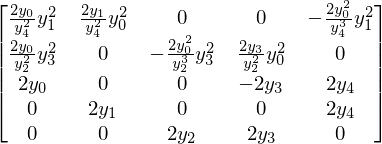

In [17]:
y_0, y_1, y_2, y_3, y_4 = y
sp.Matrix([[2*y_0*y_1**2/y_4**2, 2*y_0**2*y_1/y_4**2, 0, 0, -2*y_0**2*y_1**2/y_4**3], [2*y_0*y_3**2/y_2**2, 0, -2*y_0**2*y_3**2/y_2**3, 2*y_0**2*y_3/y_2**2, 0], [2*y_0, 0, 0, -2*y_3, 2*y_4], [0, 2*y_1, 0, 0, 2*y_4], [0, 0, 2*y_2, 2*y_3, 0]])

In [18]:
x0

In [19]:
from aqchem.equilibria import solve_equilibrium
print(x0)
for w in range(1,5):
    for eq in rs.rxns:
        new_x0 = solve_equilibrium(x0, eq.net_stoich(rs.substances), eq.params)
        x0 = (w*x0 + new_x0)/(w+1)
        print(x0)

[1e-07, 1e-07, 1e-07, 1.0, 55.5]
[  4.2249e-07   4.2249e-07   1.0000e-07   1.0000e+00   5.5500e+01]
[  2.1125e-07   4.2249e-07   3.1125e-07   1.0000e+00   5.5500e+01]
[  3.5643e-07   5.6768e-07   3.1125e-07   1.0000e+00   5.5500e+01]
[  2.3762e-07   5.6768e-07   4.3006e-07   1.0000e+00   5.5500e+01]
[  3.2772e-07   6.5778e-07   4.3006e-07   1.0000e+00   5.5500e+01]
[  2.4579e-07   6.5778e-07   5.1199e-07   1.0000e+00   5.5500e+01]
[  3.1002e-07   7.2201e-07   5.1199e-07   1.0000e+00   5.5500e+01]
[  2.4802e-07   7.2201e-07   5.7399e-07   1.0000e+00   5.5500e+01]


In [20]:
rs.root(x0, scaling=1e8, logC=False, square=False)

(array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01]),
   status: 1
 success: True
     qtf: array([  2.9509e-08,   0.0000e+00,   5.4046e-16,  -9.5322e-07,   3.4507e-14])
    nfev: 32
       r: array([ -3.0996e+01,  -5.8163e-18,   1.7565e-08,   3.2262e-02,  -3.2262e-02,   1.0000e+00,   1.0017e-25,   0.0000e+00,
         1.0000e+00,  -1.0000e+00,  -1.0000e+00,  -5.6669e-10,  -9.9948e-01,   9.9948e-01,   6.4981e-13])
     fun: array([  1.5063e-17,   2.0817e-17,   0.0000e+00,   0.0000e+00,   0.0000e+00])
       x: array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01])
 message: 'The solution converged.'
    fjac: array([[ -1.8188e-05,  -9.9948e-01,  -3.2262e-02,   0.0000e+00,   0.0000e+00],
       [  3.1969e-13,  -5.6980e-18,  -3.6994e-18,   1.0000e+00,   0.0000e+00],
       [ -3.1946e-13,   1.8292e-11,  -5.6669e-10,   1.0017e-25,  -1.0000e+00],
       [ -5.8708e-07,  -3.2262e-02,   9.9948e-01,   0.0000e+00,  -5.6698e-10],
       [ -1.0000e+

In [21]:
rs.root(x0, scaling=1, logC=False, square=False)

(array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01]),
   status: 1
 success: True
     qtf: array([  1.0916e-20,  -5.2351e-34,   5.1657e-24,   3.5231e-22,  -3.1716e-25])
    nfev: 71
       r: array([ -3.0996e+01,   4.7963e-14,   4.7330e-04,   3.2262e-02,  -3.2262e-02,   1.0000e+00,   2.0780e-14,   1.4843e-12,
         1.0000e+00,  -1.0001e+00,  -1.0145e+00,   1.4653e-02,  -9.8471e-01,   9.9937e-01,   6.5502e-13])
     fun: array([  1.1842e-25,  -1.0921e-20,   0.0000e+00,   0.0000e+00,   0.0000e+00])
       x: array([  1.7739e-11,   3.1270e-02,   3.1270e-02,   9.6873e-01,   5.5469e+01])
 message: 'The solution converged.'
    fjac: array([[ -1.8188e-05,  -9.9948e-01,  -3.2262e-02,   1.3664e-29,  -5.1094e-15],
       [  3.1969e-13,   4.7938e-14,  -1.4853e-12,   1.0000e+00,  -1.0093e-15],
       [ -8.6074e-09,  -4.7299e-04,   1.4653e-02,   2.0777e-14,  -9.9989e-01],
       [ -5.8702e-07,  -3.2259e-02,   9.9937e-01,   1.4859e-12,   1.4661e-02],
       [ -1.0000e+

In [22]:
rs.root(x0, scaling=1.0, logC=False, reduced=True)

('elim: ', [0, 1, 2])


(array([  3.1265e-02,   3.1265e-02,   1.7735e-11,   9.6874e-01,   5.5469e+01]),
   status: 1
 success: True
     qtf: array([  1.9872e-14,  -3.3048e-18])
    nfev: 52
       r: array([ -3.0985e+01,   3.0985e+01,  -6.5020e-13])
     fun: array([ -3.6663e-18,  -1.9872e-14])
       x: array([  0.9687,  55.4687])
 message: 'The solution converged.'
    fjac: array([[ -1.8191e-05,  -1.0000e+00],
       [  1.0000e+00,  -1.8191e-05]])
    njev: 5)

/home/bjorn/.local/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


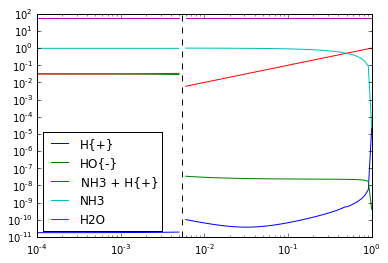

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
ny = len(rs.substances)
nc = 100
x = np.empty((nc, ny))
Hparr = np.logspace(-4, 0, nc)
success = []
for idx in range(nc):
    x00 = x0[:]
    x00[0] = Hparr[idx]
    resx, res = rs.root(x00, scaling=1e12)
    success.append(res.success)
    x[idx, :] = resx
for idx_s in range(ny):
    plt.loglog(Hparr, x[:, idx_s], label=rs.substances[idx_s].name)
plt.legend(loc='best')
for i, s in enumerate(success):
    if s is False:
        plt.axvline(Hparr[i], c='k', ls='--')